In [160]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np
import torch
from itertools import product

import nmf.mult
import nmf.pgrad
import nmf.nesterov

import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov
import nmf_torch.norms

from performance.performance_eval_func import get_random_lowrank_matrix, get_time_ratio,\
                                              compare_performance, plot_performance,\
                                              torch_algo_wrapper

In [158]:
def errors_at_time_t_over_inner_dim(V, r_range, t, algo_dict): 
    error_data  = {algo_name: [] for algo_name in algo_dict.keys()}

    for r in r_range:
        W_init, H_init = nmf.mult.update_empty_initials(V, r, None, None)
        for algo_name, algo in algo_dict.items():
            W, H = algo(V=V, inner_dim=r, 
                        record_errors=False,
                        time_limit=t,
                        max_steps=np.inf,
                        epsilon=0,
                        W_init=W_init.copy(),
                        H_init=H_init.copy()) 
            error = nmf.norms.norm_Frobenius(V - W@H)
            error_data[algo_name].append([r, error])
    return {k:np.array(v) for k,v in error_data.items()}


def errors_at_time_t_over_inner_dim_data_size(r_list, shape_list, t, algo_dict): 
    error_data  = {algo_name: {} for algo_name in algo_dict.keys()}
    
    for r_i, r in enumerate(r_list):
        for sh_i, shape in enumerate(shape_list):
            V = get_random_lowrank_matrix(shape[0], r, shape[1])
            W_init, H_init = nmf.mult.update_empty_initials(V, r, None, None)
            for algo_name, algo in algo_dict.items():
                W, H, errors = algo(V=V, inner_dim=r, 
                            record_errors=True,
                            time_limit=t,
                            max_steps=np.inf,
                            epsilon=0,
                            W_init=W_init.copy(),
                            H_init=H_init.copy()) 
                errors[:, 1] = errors[:, 1] / (shape[0] * shape[0])
                error_data[algo_name][(r_i, sh_i)] = errors
    
    data_idx_list =  list(product(algo_dict.keys(),  product(
            range(len(r_list)), 
            range(len(shape_list))
    )))
                          
    largest_final_error = np.min([
        error_data[algo_name][(r_i, sh_i)][-1, 1] 
        for algo_name, (r_i, sh_i) in data_idx_list
    ])
    
    final_grids = {
        name: np.zeros((len(r_list), len(shape_list)))
        for name in algo_dict.keys()
    }
    
    for algo_name, (r_i, sh_i) in data_idx_list:
        errors = error_data[algo_name]
        time_to_get_lfe = errors[errors[:, 1] <= largest_final_error, 0][0]
        final_grids[algo_name][r_i, sh_i] = time_to_get_lfe                          
                          
    return final_grids

In [153]:
np.zeros(10, 10)

TypeError: data type not understood

In [5]:
def plot_dict(dict_data, ax, log=False):
    for k,v in dict_data.items():
        ls = "--" if "torch" in k else "-"
        y_data = np.log(v[:, 1]) if log else v[:, 1] 
        ax.plot(v[:, 0], y_data, label=k, ls=ls)
    ax.legend()
    return ax

In [6]:
algo_dict_to_test = {
    "mult": nmf.mult.factorise_Fnorm,
    "pgrad": nmf.pgrad.factorise_Fnorm_subproblems,
    "nesterov": nmf.nesterov.factorise_Fnorm,

    "mult_torch": torch_algo_wrapper(nmf_torch.mult.factorise_Fnorm, 
                                     device="cuda"),
    "pgrad_torch": torch_algo_wrapper(nmf_torch.pgrad.factorise_Fnorm_subproblems, 
                                      device="cuda"),
    "nesterov_torch": torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, 
                                        device="cuda")
}

In [43]:
V = get_random_lowrank_matrix(2000, 50, 2000) + np.random.rand(2000, 2000) * 0.01

In [46]:
errors_result = errors_at_time_t_over_inner_dim(V, [20, 25, 30, 35, 40, 45,
                                                    50, 
                                                    55, 60, 65, 70, 75, 80, 85, 90],
                                                60, algo_dict_to_test)

<IPython.core.display.Javascript object>


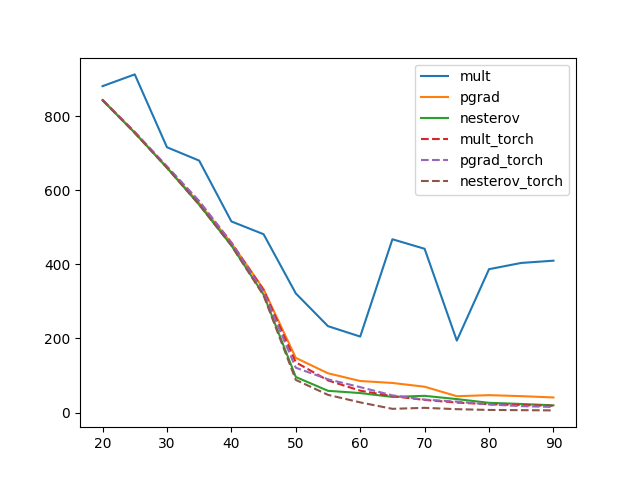

<IPython.core.display.Javascript object>


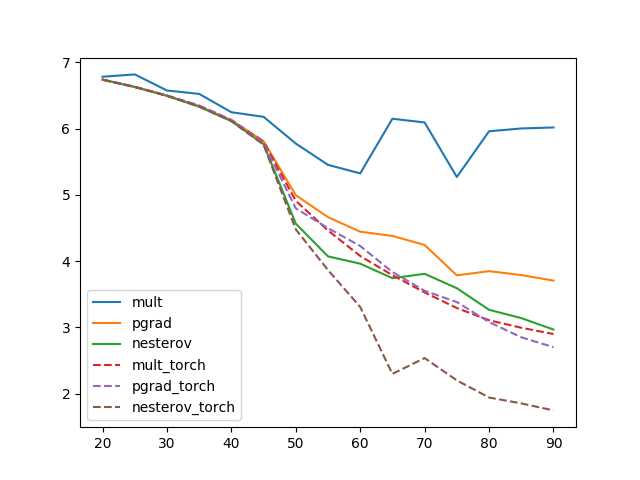

In [47]:
f, ax = plt.subplots()
plot_dict(errors_result, ax, log=False)
f, ax = plt.subplots()
plot_dict(errors_result, ax, log=True)

In [134]:
rs = list(range(2, 10))
shapes = [(a, a) for a in range(int(np.sqrt(5)), int(np.sqrt(25)) + 1)]

In [138]:
shape_res = len(rs), len(shapes)

In [161]:
errros_data = errors_at_time_t_over_inner_dim_data_size(
                                rs, shapes, 10, 
                                {"nesterov_torch":algo_dict_to_test["nesterov_torch"]})

NameError: name 'shape_list' is not defined

In [11]:
X, Y = np.meshgrid(errros_data["nesterov_torch"][0], errros_data["nesterov_torch"][1]) 

In [ ]:
def extend(grid):
    new_grid = np.array(grid.shape[0] + 1, grid.shape[1] + 1)
    
    new_grid[:-1, :-1]

In [111]:
np.sqrt(1)

1.0

In [29]:
errros_data["nesterov_torch"].shape

(9, 3)

In [104]:
def extend_x_grid(X):
    dx = (-X[1:, 1:] +  X[:-1, :-1]) / 2
    dx = np.hstack([dx[:, [0]], dx,  dx[:, [-1]]])
    dx = np.vstack([dx[[0], :], dx,  -dx[[-1], :]])

    X = np.vstack([X,  X[[-1], :]])
    X = np.hstack([X,  X[:, [-1]]])

    return X + dx

def extend_grid(X, Y):
    return extend_x_grid(X), extend_x_grid(Y.T).T

In [139]:
X = errros_data["nesterov_torch"][:, 0].reshape(shape_res)
Y = errros_data["nesterov_torch"][:, 1].reshape(shape_res)

In [108]:
X, Y = extend_grid(X, Y)

In [109]:
X

array([[1.5, 1.5, 1.5, 1.5],
       [2.5, 2.5, 2.5, 2.5],
       [3.5, 3.5, 3.5, 3.5],
       [4.5, 4.5, 4.5, 4.5]])

<IPython.core.display.Javascript object>


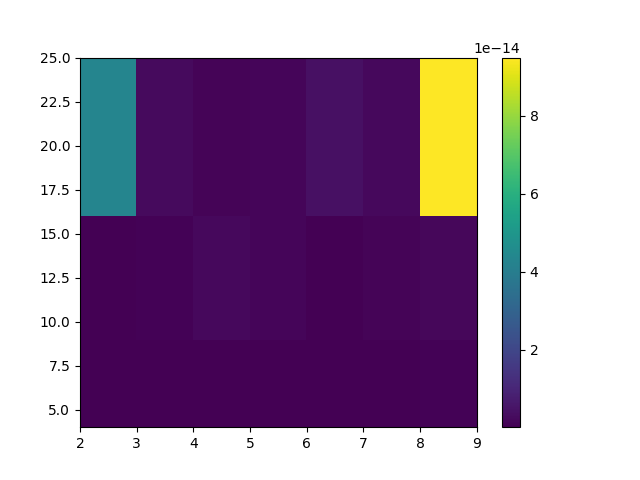

In [143]:
f, ax = plt.subplots()
im = ax.pcolor(X, Y, errros_data["nesterov_torch"][:, 2].reshape(shape_res))
f.colorbar(im) 

In [ ]:
def plot_errors_over_inner_dim_data_size(errors_data_array):
    pass


def plot_errors_id_size_one_array(errors_data):
    pass
